<a href="https://colab.research.google.com/github/deepika1715/Artificial-Intelligence/blob/main/Detecting_deepfake.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow
!pip install keras
!pip install efficientnet
!pip install kaggle

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 4.8 MB/s eta 0:00:00


In [ ]:
from google.colab import files

# Upload kaggle.json
files.upload()



Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"deepika1715","key":"9e13b3074137a4ad61588a8112ef7c5d"}'}

In [ ]:
#making .kaggle directory under root
!mkdir ~/.kaggle

In [ ]:
#moving kaggle.json to .kaggle directory
!mv kaggle.json ~/.kaggle/

In [ ]:
#changing access permision for the json file
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
import kaggle

In [ ]:
#importing required libraries
from sklearn.ensemble import RandomForestClassifier
#from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, plot_precision_recall_curve
from sklearn import tree
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
#import scikitplot as skplt

In [8]:
#downloading the dataset
#!kaggle datasets download -d fakecatcherai/dfdc-dataset
!kaggle competitions download -c deepfake-detection-challenge




100% 4.13G/4.13G [03:06<00:00, 28.0MB/s]
100% 4.13G/4.13G [03:06<00:00, 23.9MB/s]


In [9]:
!unzip /content/deepfake-detection-challenge.zip -d /content/DFDC/


Archive:  /content/deepfake-detection-challenge.zip
  inflating: /content/DFDC/sample_submission.csv  
  inflating: /content/DFDC/test_videos/aassnaulhq.mp4  
  inflating: /content/DFDC/test_videos/aayfryxljh.mp4  
  inflating: /content/DFDC/test_videos/acazlolrpz.mp4  
  inflating: /content/DFDC/test_videos/adohdulfwb.mp4  
  inflating: /content/DFDC/test_videos/ahjnxtiamx.mp4  
  inflating: /content/DFDC/test_videos/ajiyrjfyzp.mp4  
  inflating: /content/DFDC/test_videos/aktnlyqpah.mp4  
  inflating: /content/DFDC/test_videos/alrtntfxtd.mp4  
  inflating: /content/DFDC/test_videos/aomqqjipcp.mp4  
  inflating: /content/DFDC/test_videos/apedduehoy.mp4  
  inflating: /content/DFDC/test_videos/apvzjkvnwn.mp4  
  inflating: /content/DFDC/test_videos/aqrsylrzgi.mp4  
  inflating: /content/DFDC/test_videos/axfhbpkdlc.mp4  
  inflating: /content/DFDC/test_videos/ayipraspbn.mp4  
  inflating: /content/DFDC/test_videos/bcbqxhziqz.mp4  
  inflating: /content/DFDC/test_videos/bcvheslzrq.mp4  
 

In [10]:
#code for splitting data into 80% training and 20% validation
import os # Import the os module
import json # Import the json module
import shutil
from sklearn.model_selection import train_test_split

# Paths to dataset directories
data_dir = "/content/DFDC/train_sample_videos"
train_dir = "/content/DFDC/train_videos"
val_dir = "/content/DFDC/validation_videos"

# Load the metadata file that contains labels
metadata_path = os.path.join(data_dir, 'metadata.json')
with open(metadata_path, 'r') as f:
    metadata = json.load(f)

# Create lists for real and fake videos based on metadata
real_videos = [video for video, info in metadata.items() if info['label'] == 'REAL']
fake_videos = [video for video, info in metadata.items() if info['label'] == 'FAKE']

# Split the videos into train and validation sets
train_real, val_real = train_test_split(real_videos, test_size=0.2, random_state=42)
train_fake, val_fake = train_test_split(fake_videos, test_size=0.2, random_state=42)

# Function to move files
def move_files(video_list, dest_dir):
    os.makedirs(dest_dir, exist_ok=True)
    for video in video_list:
        src_path = os.path.join(data_dir, video)
        dest_path = os.path.join(dest_dir, video)
        if os.path.exists(src_path):
            shutil.copy(src_path, dest_path)

# Create real and fake folders inside train and validation directories
os.makedirs(os.path.join(train_dir, 'real'), exist_ok=True)
os.makedirs(os.path.join(train_dir, 'fake'), exist_ok=True)
os.makedirs(os.path.join(val_dir, 'real'), exist_ok=True)
os.makedirs(os.path.join(val_dir, 'fake'), exist_ok=True)

# Move the files
move_files(train_real, os.path.join(train_dir, 'real'))
move_files(train_fake, os.path.join(train_dir, 'fake'))
move_files(val_real, os.path.join(val_dir, 'real'))
move_files(val_fake, os.path.join(val_dir, 'fake'))

print("Training and validation data split completed.")

Training and validation data split completed.


In [11]:
# extracting frames from videos for training data
import cv2

# Paths to the 'real' and 'fake' directories containing videos
train_real_video_dir = '/content/DFDC/train_videos/real'
train_fake_video_dir = '/content/DFDC/train_videos/fake'

# Paths to save the extracted frames
train_real_frames_dir = '/content/DFDC/train_frames/real'
train_fake_frames_dir = '/content/DFDC/train_frames/fake'

# Function to extract frames from a video and save them to a directory
def extract_frames(video_path, output_dir, frame_rate=1):
    # Create the output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Open the video file
    video_cap = cv2.VideoCapture(video_path)
    count = 0
    success = True
    fps = video_cap.get(cv2.CAP_PROP_FPS)
    interval = int(fps // frame_rate)  # Calculate interval to capture frames

    while success:
        success, frame = video_cap.read()
        if success and count % interval == 0:
            # Save the frame as an image file
            frame_filename = os.path.join(output_dir, f"frame_{count:04d}.jpg")
            cv2.imwrite(frame_filename, frame)
        count += 1

    # Release the video capture object
    video_cap.release()

# Function to process all videos in a directory
def process_videos_in_directory(video_dir, frames_dir):
    for video_name in os.listdir(video_dir):
        video_path = os.path.join(video_dir, video_name)
        video_output_dir = os.path.join(frames_dir, os.path.splitext(video_name)[0])

        # Extract frames from the video
        extract_frames(video_path, video_output_dir)

# Extract frames from 'real' videos
process_videos_in_directory(train_real_video_dir, train_real_frames_dir)

# Extract frames from 'fake' videos
process_videos_in_directory(train_fake_video_dir, train_fake_frames_dir)

print("Train frames extraction completed.")


Train frames extraction completed.


In [12]:
# extracting frames from videos for validation data
import cv2

# Paths to the 'real' and 'fake' directories containing videos
validation_real_video_dir = '/content/DFDC/validation_videos/real'
validation_fake_video_dir = '/content/DFDC/validation_videos/fake'

# Paths to save the extracted frames
validation_real_frames_dir = '/content/DFDC/validation_frames/real'
validation_fake_frames_dir = '/content/DFDC/validation_frames/fake'

# Function to extract frames from a video and save them to a directory
def extract_frames(video_path, output_dir, frame_rate=1):
    # Create the output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Open the video file
    video_cap = cv2.VideoCapture(video_path)
    count = 0
    success = True
    fps = video_cap.get(cv2.CAP_PROP_FPS)
    interval = int(fps // frame_rate)  # Calculate interval to capture frames

    while success:
        success, frame = video_cap.read()
        if success and count % interval == 0:
            # Save the frame as an image file
            frame_filename = os.path.join(output_dir, f"frame_{count:04d}.jpg")
            cv2.imwrite(frame_filename, frame)
        count += 1

    # Release the video capture object
    video_cap.release()

# Function to process all videos in a directory
def process_videos_in_directory(video_dir, frames_dir):
    for video_name in os.listdir(video_dir):
        video_path = os.path.join(video_dir, video_name)
        video_output_dir = os.path.join(frames_dir, os.path.splitext(video_name)[0])

        # Extract frames from the video
        extract_frames(video_path, video_output_dir)

# Extract frames from 'real' videos
process_videos_in_directory(validation_real_video_dir, validation_real_frames_dir)

# Extract frames from 'fake' videos
process_videos_in_directory(validation_fake_video_dir, validation_fake_frames_dir)

print("Validation frames extraction completed.")

Validation frames extraction completed.


In [13]:
# splitting test data into real and fake folders
import json
from sklearn.model_selection import train_test_split

# Paths to dataset directories
test_data_dir = "/content/DFDC/test_data"


# Load the metadata file that contains labels
metadata_path = os.path.join(data_dir, 'metadata.json')
with open(metadata_path, 'r') as f:
    metadata = json.load(f)

# Create lists for test videos based on metadata
real_videos = [video for video, info in metadata.items() if info['label'] == 'REAL']
fake_videos = [video for video, info in metadata.items() if info['label'] == 'FAKE']

# Split the videos into test sets
test_real = train_test_split(real_videos, test_size=0.2, random_state=42)[0]  # Keep only the training part
test_fake = train_test_split(fake_videos, test_size=0.2, random_state=42)[0]  # Keep only the training part

# Function to move files
def move_files(video_list, src_dir, dest_dir):
    os.makedirs(dest_dir, exist_ok=True)
    for video in video_list:
        src_path = os.path.join(src_dir, video)
        dest_path = os.path.join(dest_dir, video)
        if os.path.exists(src_path):
            shutil.copy(src_path, dest_path)
        else:
            print(f"Warning: {src_path} does not exist.")

# Create real and fake folders inside test directories
os.makedirs(os.path.join(test_data_dir, 'real'), exist_ok=True)
os.makedirs(os.path.join(test_data_dir, 'fake'), exist_ok=True)


# Move the files from the original data directory to the test directories
move_files(test_real, data_dir, os.path.join(test_data_dir, 'real'))
move_files(test_fake, data_dir, os.path.join(test_data_dir, 'fake'))

print("Splitting test data into real and fake folders completed.")

Splitting test data into real and fake folders completed.


In [14]:

import cv2
import os
import json

def extract_frames(video_path, output_folder, frame_rate=1):
    video_capture = cv2.VideoCapture(video_path)
    count = 0
    success, image = video_capture.read()
    while success:
        if count % frame_rate == 0:
            cv2.imwrite(os.path.join(output_folder, f"frame_{count}.jpg"), image)
        success, image = video_capture.read()
        count += 1
    video_capture.release()

# Example usage:
extract_frames('/content/DFDC/test_videos', '/content/DFDC/test_frames')




In [15]:
#extracting test frames

import cv2

# Paths to the 'real' and 'fake' directories containing videos
test_real_video_dir = '/content/DFDC/test_data/real'
test_fake_video_dir = '/content/DFDC/test_data/fake'

# Paths to save the extracted frames
test_real_frames_dir = '/content/DFDC/test_frames/real'
test_fake_frames_dir = '/content/DFDC/test_frames/fake'

# Function to extract frames from a video and save them to a directory
def extract_frames(video_path, output_dir, frame_rate=1):
    # Create the output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Open the video file
    video_cap = cv2.VideoCapture(video_path)
    count = 0
    success = True
    fps = video_cap.get(cv2.CAP_PROP_FPS)
    interval = int(fps // frame_rate)  # Calculate interval to capture frames

    while success:
        success, frame = video_cap.read()
        if success and count % interval == 0:
            # Save the frame as an image file
            frame_filename = os.path.join(output_dir, f"frame_{count:04d}.jpg")
            cv2.imwrite(frame_filename, frame)
        count += 1

    # Release the video capture object
    video_cap.release()

# Function to process all videos in a directory
def process_videos_in_directory(video_dir, frames_dir):
    for video_name in os.listdir(video_dir):
        video_path = os.path.join(video_dir, video_name)
        video_output_dir = os.path.join(frames_dir, os.path.splitext(video_name)[0])

        # Extract frames from the video
        extract_frames(video_path, video_output_dir)

# Extract frames from 'real' videos
process_videos_in_directory(test_real_video_dir, test_real_frames_dir)

# Extract frames from 'fake' videos
process_videos_in_directory(test_fake_video_dir, test_fake_frames_dir)


print("Extracting test frames completed.")

Extracting test frames completed.


In [16]:

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Directory structure - Verify that these directories exist and contain images
train_dir = '/content/DFDC/train_frames'
val_dir = '/content/DFDC/validation_frames'

# Print the number of images found in each directory
print("Number of images in training directory:", len(os.listdir(train_dir)))
print("Number of images in validation directory:", len(os.listdir(val_dir)))

# Example data generators
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

# Check if generators are yielding data
print("Training generator yields data:", bool(next(train_generator, None)))
print("Validation generator yields data:", bool(next(validation_generator, None)))

Number of images in training directory: 2
Number of images in validation directory: 2
Found 2808 images belonging to 2 classes.
Found 178 images belonging to 2 classes.
Training generator yields data: True
Validation generator yields data: True


In [17]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Directory structure - Verify that these directories exist and contain images
train_dir = '/content/DFDC/train_frames'
val_dir = '/content/DFDC/validation_frames'
test_dir = '/content/DFDC/test_frames' # Assuming you have a test directory

# ... (rest of the code remains the same)

# Create a test generator
test_datagen = ImageDataGenerator(rescale=1./255) # You might

In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Directory containing test data
test_dir = '/content/DFDC/test_frames'

# Create a data generator for test data
test_datagen = ImageDataGenerator(rescale=1./255)  # No augmentation for testing

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',  # Assuming binary classification
    shuffle=False  # Important for evaluation to ensure predictions correspond to the correct labels
)


Found 3509 images belonging to 2 classes.


In [19]:
# Verify test_generator
print(test_generator.class_indices)  # Check class indices
print(len(test_generator.filenames))  # Check number of test samples


{'fake': 0, 'real': 1}
3509


In [20]:
test_datagen = ImageDataGenerator(rescale=1./255)


In [21]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)


Found 3509 images belonging to 2 classes.


In [22]:
# Evaluate on a batch from the generator
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model

# Build the model using EfficientNetB0
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)  # Adding dropout for regularization
predictions = Dense(1, activation='sigmoid')(x)  # Binary classification

model = Model(inputs=base_model.input, outputs=predictions)
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(),
                       tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])

x_batch, y_batch = next(test_generator)
# Store evaluation results in a single variable
evaluation_results = model.evaluate(x_batch, y_batch)

# Access individual metrics by index
test_loss = evaluation_results[0]
test_accuracy = evaluation_results[1]
print(f'Test loss: {test_loss:.2f}, Test accuracy: {test_accuracy:.2f}')

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 1.0000 - auc: 0.0000e+00 - loss: 0.6795 - precision: 0.0000e+00 - recall: 0.0000e+00
Test loss: 0.68, Test accuracy: 1.00


In [23]:
# Evaluate on a batch from the generator
if len(test_generator.filenames) == 0:
    print("Error: No test samples found in the directory.")
else:
    # Evaluate on a batch from the generator
    x_batch, y_batch = next(test_generator)
    evaluation_results = model.evaluate(x_batch, y_batch) # Store evaluation results in a single variable

    # Access individual metrics by index
    test_loss = evaluation_results[0]
    test_accuracy = evaluation_results[1]
    print(f'Test loss: {test_loss:.2f}, Test accuracy: {test_accuracy:.2f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step - accuracy: 1.0000 - auc: 0.0000e+00 - loss: 0.6794 - precision: 0.0000e+00 - recall: 0.0000e+00
Test loss: 0.68, Test accuracy: 1.00


In [ ]:
import shutil # Import the shutil module
folder_path = '/content/DFDC/test_frames/real'
shutil.rmtree(folder_path)

Found 3509 images belonging to 3 classes.
Found 891 images belonging to 3 classes.
Found 3509 images belonging to 3 classes.
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


110/110 ━━━━━━━━━━━━━━━━━━━━ 195s 1s/step - accuracy: 0.7585 - auc_1: 0.0000e+00 - loss: -3.7536 - precision_1: 1.0000 - recall_1: 0.9356 - val_accuracy: 0.8025 - val_auc_1: 0.0000e+00 - val_loss: -1.1833 - val_precision_1: 1.0000 - val_recall_1: 1.0000
Epoch 2/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 89s 776ms/step - accuracy: 0.7826 - auc_1: 0.0000e+00 - loss: -21.3941 - precision_1: 1.0000 - recall_1: 0.9728 - val_accuracy: 0.8025 - val_auc_1: 0.0000e+00 - val_loss: -3.2521 - val_precision_1: 1.0000 - val_recall_1: 1.0000
Epoch 3/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 86s 739ms/step - accuracy: 0.7484 - auc_1: 0.0000e+00 - loss: -27.9058 - precision_1: 1.0000 - recall_1: 0.9267 - val_accuracy: 0.8025 - val_auc_1: 0.0000e+00 - val_loss: -4.9897 - val_precision_1: 1.0000 - val_recall_1: 1.0000
Epoch 4/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 85s 734ms/step - accuracy: 0.8109 - auc_1: 0.0000e+00 - loss: -38.5045 - precision_1: 1.0000 - recall_1: 1.0000 - val_accuracy: 0.8025 - val_auc_1: 0.0000e+00 - val_loss:

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


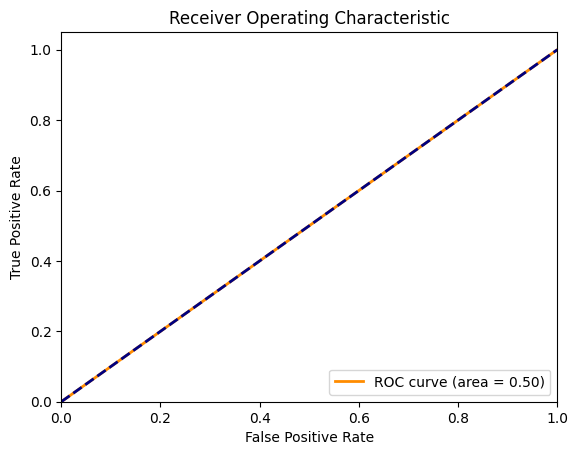

In [ ]:
!pip install tensorflow scikit-learn matplotlib

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, roc_auc_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model

train_dir = '/content/DFDC/train_frames'
val_dir = '/content/DFDC/validation_frames'
test_dir = '/content/DFDC/test_frames'

# Image data generator for data augmentation
datagen = ImageDataGenerator(rescale=1./255, rotation_range=20, width_shift_range=0.2,
                             height_shift_range=0.2, shear_range=0.2, zoom_range=0.2,
                             horizontal_flip=True, fill_mode='nearest')

# Load the train, validation, and test data
train_generator = datagen.flow_from_directory(train_dir, target_size=(224, 224),
                                              batch_size=32, class_mode='binary')
val_generator = datagen.flow_from_directory(val_dir, target_size=(224, 224),
                                            batch_size=32, class_mode='binary')
test_generator = datagen.flow_from_directory(test_dir, target_size=(224, 224),
                                             batch_size=32, class_mode='binary', shuffle=False)

# Build the model using EfficientNetB0
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)  # Adding dropout for regularization
predictions = Dense(1, activation='sigmoid')(x)  # Binary classification

model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(),
                       tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])

# Train the model
model.fit(train_generator, epochs=20, validation_data=val_generator)

# Evaluate the model on test data
test_loss, test_accuracy, test_precision, test_recall, test_auc = model.evaluate(test_generator)
y_pred = model.predict(test_generator)
y_true = test_generator.classes

# Adjust y_true values to be 0 or 1
y_true = np.where(y_true == 2, 1, 0)  # Replace 2 with 1, leave others unchanged

# Calculate F1-score
f1_score = 2 * (test_precision * test_recall) / (test_precision + test_recall)


# Print out the results
print(f"Accuracy: {test_accuracy * 100:.2f}%")
print(f"Precision: {test_precision * 100:.2f}%")
print(f"Recall: {test_recall * 100:.2f}%")
print(f"F1-score: {f1_score * 100:.2f}%")
print(f"AUC-ROC (TensorFlow): {test_auc:.2f}")

# For a detailed classification report
print("\nClassification Report:")
print(classification_report(y_true, (y_pred > 0.5).astype(int)))

# AUC-ROC score using sklearn
auc_roc = roc_auc_score(y_true, y_pred)
print(f"AUC-ROC (sklearn): {auc_roc:.2f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, (y_pred > 0.5).astype(int))
print("\nConfusion Matrix:")
print(conf_matrix)

# Plotting the AUC-ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


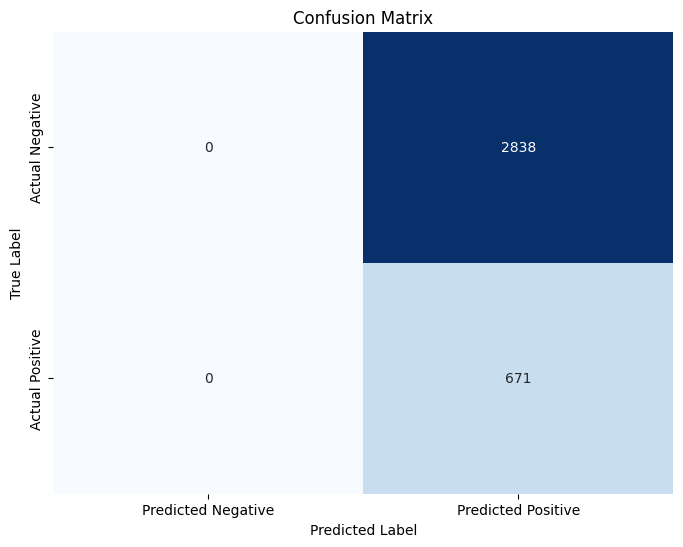

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Given confusion matrix
conf_matrix = [[0, 2838], [0, 671]]

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB7  # Upgrade to EfficientNetB7
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, roc_auc_score
import seaborn as sns

# Enable mixed precision training
tf.keras.mixed_precision.set_global_policy('mixed_float16')


train_dir = '/content/DFDC/train_frames'
val_dir = '/content/DFDC/validation_frames'
test_dir = '/content/DFDC/test_frames'


# Image data generator for data augmentation
datagen = ImageDataGenerator(rescale=1./255, rotation_range=20, width_shift_range=0.2,
                             height_shift_range=0.2, shear_range=0.2, zoom_range=0.2,
                             horizontal_flip=True, fill_mode='nearest')

# Load the train, validation, and test data
train_generator = datagen.flow_from_directory(train_dir, target_size=(224, 224),
                                              batch_size=32, class_mode='binary')
val_generator = datagen.flow_from_directory(val_dir, target_size=(224, 224),
                                            batch_size=32, class_mode='binary')
test_generator = datagen.flow_from_directory(test_dir, target_size=(224, 224),
                                             batch_size=32, class_mode='binary', shuffle=False)




# Build the model using EfficientNetB7
base_model = EfficientNetB7(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Unfreeze the top layers of the model for fine-tuning
for layer in base_model.layers[-20:]:  # Fine-tune the last 20 layers
    layer.trainable = True

# Add new layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)  # Adjust units to balance performance
x = Dropout(0.4)(x)  # Adjusted dropout rate to combat overfitting
predictions = Dense(1, activation='sigmoid')(x)  # Binary classification

model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model with AdamW optimizer and a learning rate schedule
initial_learning_rate = 0.0003
model.compile(
    optimizer=AdamW(learning_rate=initial_learning_rate),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(),
             tf.keras.metrics.Recall(), tf.keras.metrics.AUC()]
)

# Enable XLA for potential speedup
tf.config.optimizer.set_jit(True)

# Callbacks to improve training
# Callbacks to improve training
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1),  # Dynamic learning rate reduction
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),  # Balanced patience
    ModelCheckpoint(filepath='best_model.weights.h5', monitor='val_loss', save_best_only=True, save_weights_only=True) # Changed filename to end with '.weights.h5'
]
# Check if the generators are working
print("Number of training batches:", len(train_generator))
print("Number of validation batches:", len(val_generator))

# Try to get a batch from each generator
X_train_batch, y_train_batch = train_generator.__next__() # Use __next__() instead of .next()
X_val_batch, y_val_batch = val_generator.__next__() # Use __next__() instead of .next()

print("Shape of a training batch (X, y):", X_train_batch.shape, y_train_batch.shape)
print("Shape of a validation batch (X, y):", X_val_batch.shape, y_val_batch.shape)

# Train the model
history = model.fit(
    train_generator, epochs=20, validation_data=val_generator,
    callbacks=callbacks, steps_per_epoch=len(train_generator), validation_steps=len(val_generator)
)

# Evaluate the model on test data
test_loss, test_accuracy, test_precision, test_recall, test_auc = model.evaluate(test_generator)
y_pred = model.predict(test_generator)
y_true = test_generator.classes

# Calculate F1-score
f1_score = 2 * (test_precision * test_recall) / (test_precision + test_recall)

# Print out the results
print(f"Accuracy: {test_accuracy * 100:.2f}%")
print(f"Precision: {test_precision * 100:.2f}%")
print(f"Recall: {test_recall * 100:.2f}%")
print(f"F1-score: {f1_score * 100:.2f}%")
print(f"AUC-ROC (TensorFlow): {test_auc:.2f}")

# For a detailed classification report
print("\nClassification Report:")
print(classification_report(y_true, (y_pred > 0.5).astype(int)))

# AUC-ROC score using sklearn
auc_roc = roc_auc_score(y_true, y_pred)
print(f"AUC-ROC (sklearn): {auc_roc:.2f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, (y_pred > 0.5).astype(int))
print("\nConfusion Matrix:")
print(conf_matrix)

# Plotting the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Plotting the AUC-ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()



Found 3509 images belonging to 2 classes.
Found 891 images belonging to 2 classes.
Found 3509 images belonging to 2 classes.
Number of training batches: 110
Number of validation batches: 28
Shape of a training batch (X, y): (32, 224, 224, 3) (32,)
Shape of a validation batch (X, y): (32, 224, 224, 3) (32,)
Epoch 1/20
  1/110 ━━━━━━━━━━━━━━━━━━━━ 14:03:14 464s/step - accuracy: 0.5625 - auc_5: 0.4420 - loss: 1.3502 - precision_5: 0.1429 - recall_5: 0.5000